### Simple COVID-19 stochastic model based on Anderson et al. (_Lancet 2020_)

Below I define a stochastic version of the model defined diagrammatically below taken from Anderson et al. (_Lancet 2020_), linked here: https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30567-5/fulltext.

<img src="diagram-from-Anderson2020.png" width="600"/>

Note that in the epidemology of an SEIR model, the formalism usually indicates that, in this case, $\lambda = [\beta (I_1+I^{\rm mild}_2+I^{\rm mild}_3+bI^{\rm severe}_2+bI^{\rm severe}_3) + \beta'(Y_2+Y_3) + \beta''E]/N_{\rm tot}$. First the following imports are necessary...

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Then the model parameters (all in units of 1/day) and initial compartment numbers must be defined (these have been taken from SI3 of the Anderson et al. article here: https://www.thelancet.com/cms/10.1016/S0140-6736(20)30567-5/attachment/bcade790-6075-4a41-8fbd-f65e77d727bf/mmc3.pdf)...

In [20]:
b, bet, betp, betpp, sig, gam1, gam2, gam3, alph, p = 0.8, 0.15, 0.1, 0.0, 1.0, 0.2, 1.0/7.0, 1.0/7.0, 1.0/2.0, 0.5
S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R = 9995, 5, 0, 0, 0, 0, 0, 0, 0, 0

Finally, the number of realisations and the number of days to run must be chosen...

In [21]:
nreals = 100
ndays = 250

The model is coded in the following function...

In [22]:
# Package parameters and initial conditions all together
params = [b, bet, betp, betpp, sig, gam1, gam2, gam3, alph, p]
initconds = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
             I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
             Y3*np.ones(nreals), R*np.ones(nreals)]
# Define model function to output after specified time period
def covid_simple(initconds,params,reals,runtime,output_to_file): 
    # Open storage for output to file
    f = open(output_to_file, "w")
    # Unpack parameters and initial conditions
    [b, bet, betp, betpp, sig, gam1, gam2, gam3, alph, p] = params
    [S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R] = initconds 
    # Convert to float because I'm like that...
    runtime = float(runtime)   
    # Compute total population number for each realisation
    Ntot = S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3+R
    # Main loop
    t = np.zeros(reals)
    terminated = np.ones(reals)
    while np.any(t < runtime):
        # Terminate loop if everyone has recovered
        if np.all(S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3) == 0: break
        # Update the event rates
        rate_S_E = (bet*(I1+I2mild+b*I2severe+I3mild+b*I3severe)+betp*(Y2+Y3)+betpp*E)*S/Ntot 
        rate_E_I1, rate_I1_I2, rate_I2severe_Y2 = sig*E, gam1*I1, alph*I2severe
        rate_I2mild_I3mild, rate_I2severe_I3severe, rate_Y2_Y3 = gam2*I2mild, gam2*I2severe, gam2*Y2
        rate_I3mild_R, rate_I3severe_R, rate_Y3_R = gam3*I3mild, gam3*I3severe, gam3*Y3       
        # Sum the rates
        rate_sum = rate_S_E + rate_E_I1 + rate_I1_I2 + rate_I2severe_Y2 + rate_I2mild_I3mild + \
                   rate_I2severe_I3severe + rate_Y2_Y3 + rate_I3mild_R + rate_I3severe_R + rate_Y3_R
        # Avoid pathologies at the end
        rate_sum[rate_sum<=0.0] = 1.0
        # Take step forward in time and determine when to stop each run
        t = t + terminated*np.random.exponential(1.0/rate_sum,size=reals) 
        terminated = (t<runtime)
        # Choose the event to occur in each realisation
        severe = np.random.binomial(1,p,size=reals)
        event = np.random.uniform(size=reals)
        event_probs = np.asarray([rate_S_E/rate_sum,rate_E_I1/rate_sum,\
                                  rate_I1_I2/rate_sum,rate_I2severe_Y2/rate_sum,rate_I2mild_I3mild/rate_sum,\
                                  rate_I2severe_I3severe/rate_sum,rate_Y2_Y3/rate_sum,rate_I3mild_R/rate_sum,\
                                  rate_I3severe_R/rate_sum,rate_Y3_R/rate_sum])
        cumul_probs = np.cumsum(event_probs,axis=0)
        # S -> E
        S = S - terminated*(event<cumul_probs[0])
        # S -> E, E -> I1
        E = E + terminated*(event<cumul_probs[0]) - terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0])
        # E -> I1, I1 -> I2
        I1 = I1 + terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0]) \
                - terminated*(cumul_probs[2]>event)*(event>=cumul_probs[1])
        # I1 -> I2mild, I2mild -> I3mild
        I2mild = I2mild + terminated*(severe==0)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                        - terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3])
        # I1 -> I2severe, I2severe -> Y2, I2severe -> I3severe
        I2severe = I2severe + terminated*(severe==1)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                            - terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                            - terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4])
        # I2mild -> I3mild, I3mild -> R
        I3mild = I3mild + terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3]) \
                        - terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6])
        # I2severe -> I3severe, I3severe -> R
        I3severe = I3severe + terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4]) \
                            - terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7])
        # I2severe -> Y2, Y2 -> Y3
        Y2 = Y2 + terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                - terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5])
        # Y2 -> Y3, Y3 -> R
        Y3 = Y3 + terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5]) \
                - terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # I3mild -> R, I3severe -> R, Y3 -> R
        R = R + terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6]) \
              + terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7]) \
              + terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # Store values in file
        f.write(','.join(map(str,np.concatenate([t, S, E, I1, I2mild, I2severe, \
                                                 I3mild, I3severe, Y2, Y3, R]).ravel().tolist()))+'\n')
        f.flush()
    # Close file
    f.close()
    # Setup output column name list
    column_names = []
    for l in ['t', 'S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R']:
        for r in range(0,nreals):
            column_names.append(l+'_'+str(r))
    # Load dataframe with column names
    df = pd.read_csv(output_to_file,names=column_names)
    # Create dictionary of sub dataframes from output for each time series realisation
    dict_of_dfs = {}
    for r in range(0,nreals):
        dict_of_dfs['real_'+str(r)] = df[['t_'+str(r), 'S_'+str(r), 'E_'+str(r), 'Ii_'+str(r),\
                                          'Iiimild_'+str(r), 'Iiisevere_'+str(r), 'Iiiimild_'+str(r),\
                                          'Iiiisevere_'+str(r), 'Yii_'+str(r), 'Yiii_'+str(r), 'R_'+str(r)]]
        # Strip the time column of its number for merging
        dict_of_dfs['real_'+str(r)].columns = dict_of_dfs['real_'+str(r)].columns.str.rstrip('_'+str(r))
    # Output resulting compartment numbers to a dictionary of pandas dataframes
    return dict_of_dfs

Let's run the code and create a time-merged dataframe with all of the realisations and compartments as columns...

In [23]:
# Run code and obtain dictionary of dataframes output
ddf = covid_simple(initconds,params,nreals,ndays,'plot_data/test.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df = ddf['real_0']
merged_df.columns = merged_df.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf['real_'+str(r)].columns = ddf['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df = pd.merge_asof(merged_df,ddf['real_'+str(r)],on='t')
# Set index to time
merged_df = merged_df.set_index('t')
merged_df

,S_0,E_0,Ii_0,Iiimild_0,Iiisevere_0,Iiiimild_0,Iiiisevere_0,Yii_0,Yiii_0,R_0,...,S_99,E_99,Ii_99,Iiimild_99,Iiisevere_99,Iiiimild_99,Iiiisevere_99,Yii_99,Yiii_99,R_99
t,,,,,,,,,,,,,,,,,,,,,
0.017707,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.486691,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.326986,9995.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9993.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.371663,9995.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9993.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.060655,9995.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9993.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250.030760,1067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8933.0,...,1089.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8911.0
250.030760,1067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8933.0,...,1089.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8911.0
250.030760,1067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8933.0,...,1089.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8911.0


Let's first plot the mean and 95% credible region for each compartment...

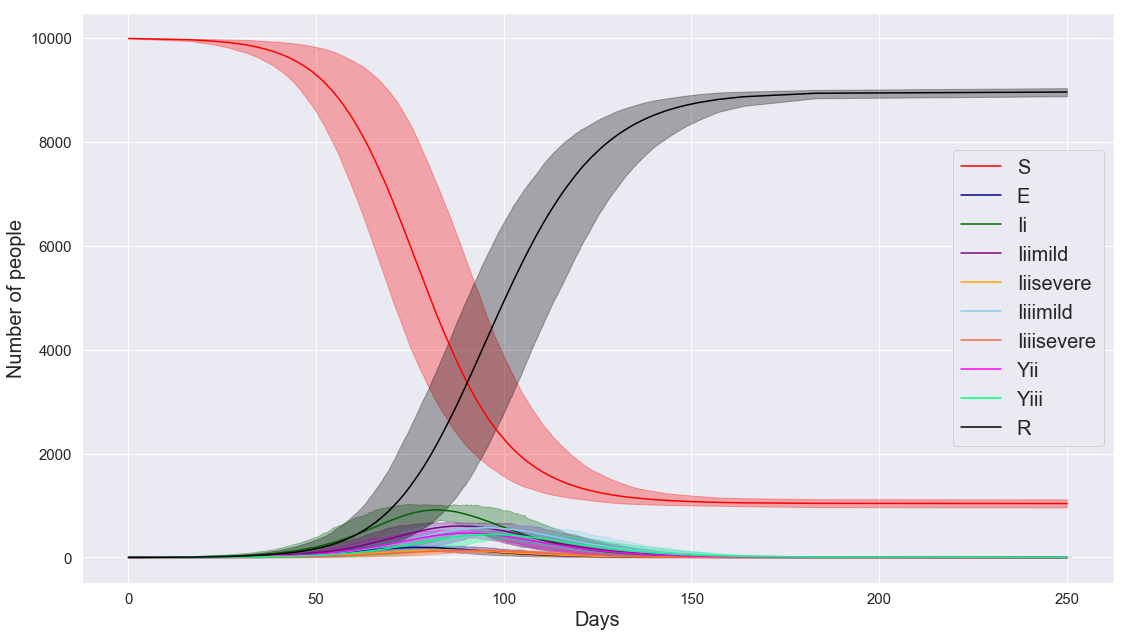

In [24]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Plotting the effective reproduction number and epidemic growth rate

We need to do a little bit of linear algebra to compute the basic reproduction number $R_0$ of the system. At the disease-free equilibrium, $S=N_{\rm tot}$ and all other compartments vanish, hence, using the vector space of infected compartments $(E,I_1,I_2^{\rm mild},I_2^{\rm severe},I_3^{\rm mild},I_3^{\rm severe},Y_2,Y_3)^{\rm T}$, the next-generation matrix (see here: https://en.wikipedia.org/wiki/Next-generation_matrix) for the above model is pretty trivial

$$F=(\lambda S,0,0,0,0,0,0,0)^{\rm T}$$

$$V=[\sigma E,\gamma_1I_1-\sigma E,\gamma_2 I^{\rm mild}_2-\gamma_1(1-p)I_1,(\gamma_2+\alpha )I^{\rm severe}_2-\gamma_1pI_1,\gamma_3I_3^{\rm mild}-\gamma_2I^{\rm mild}_2,\gamma_3I^{\rm severe}_3-\gamma_2I_2^{\rm severe},\gamma_2Y_2-\alpha I^{\rm severe}_2,\gamma_3Y_3-\gamma_2Y_2]^{\rm T}$$

$${\cal J}(F) = \begin{pmatrix} \beta'' & \beta & \beta & \beta b  & \beta  & \beta b & \beta' &  \beta' \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{pmatrix}$$ 

$${\cal J}(V) = \begin{pmatrix} \sigma  & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ -\sigma & \gamma_1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & -\gamma_1(1-p) & \gamma_2 & 0 & 0 & 0 & 0 & 0 \\ 0 & -\gamma_1p & 0 & \gamma_2+\alpha & 0 & 0 & 0 & 0 \\ 0 & 0 & -\gamma_2 & 0 & \gamma_3 & 0 & 0 & 0 \\ 0 & 0 & 0 & -\gamma_2 & 0 & \gamma_3 & 0 & 0 \\ 0 & 0 & 0 & -\alpha & 0 & 0 & \gamma_2 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -\gamma_2 & \gamma_3 \end{pmatrix}$$

$$\Longrightarrow {\rm NGM} =  {\cal J}(F){\cal J}(V)^{-1} \Longrightarrow \rho ({\rm NGM}) = R_0 = \frac{\beta''}{\sigma} + \frac{\beta}{\gamma_1} + \frac{\beta (1-p)}{\gamma_2} + \frac{\beta b p}{\alpha + \gamma_2} + \frac{\beta (1-p)}{\gamma_3} + \frac{\beta b \gamma_2p}{(\alpha + \gamma_2)\gamma_3} + \frac{\beta' \alpha p}{(\alpha + \gamma_2)\gamma_2} + \frac{\beta' \alpha p}{(\alpha + \gamma_2)\gamma_3}\,,$$

where $\rho (\cdot )$ just denotes the spectral radius. The effective reproduction number $R_t$ at time $t$ in this model is simply $R_t = R_0 (S/N_{\rm tot})$ and the epidemic growth rate $r_t$ is numerically calculable from $r_t = \delta \ln (I_1+I^{\rm mild}_2+I^{\rm severe}_2+I^{\rm mild}_3+I^{\rm severe}_3+Y_2+Y_3) / \delta t$, hence, the output data can also be plotted to give these values...

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


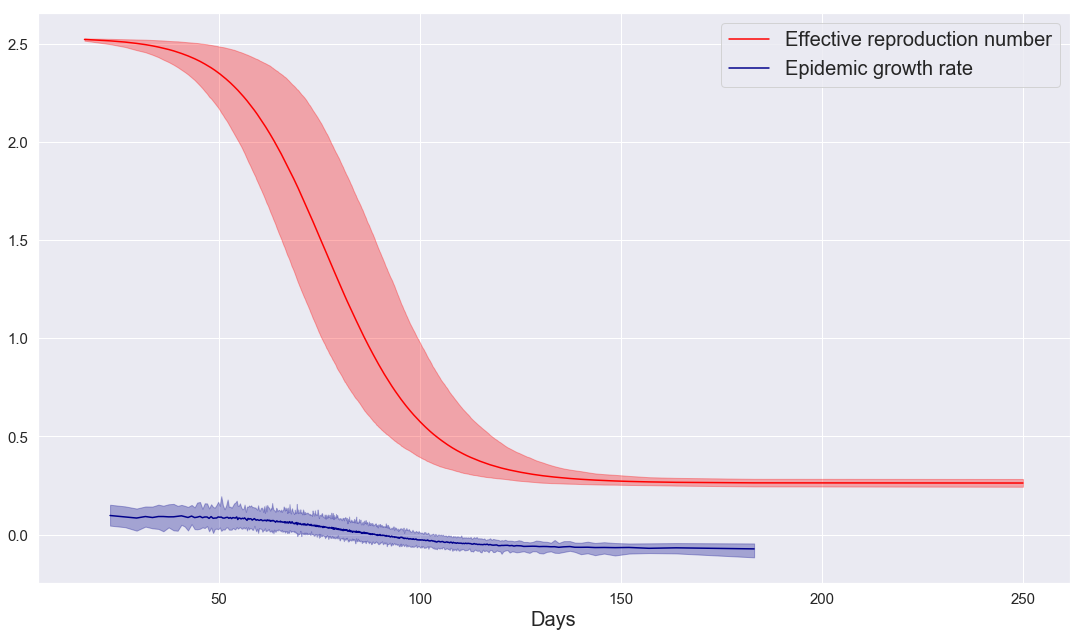

In [25]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Pull out values from merged dataframe
S_df = merged_df[['S_'+str(r) for r in range(0,nreals)]]
E_df = merged_df[['E_'+str(r) for r in range(0,nreals)]]
Ii_df = merged_df[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df = merged_df[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df = merged_df[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df = merged_df[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df = merged_df[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df = merged_df[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df = merged_df[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df = merged_df[['R_'+str(r) for r in range(0,nreals)]]
# Compute the total infected, the basic and effective reproduction numbers and epidemic growth rate
times = Ii_df.iloc[::plot_every_n, :].index
timesteps = np.diff(times)
totpop = S_df.iloc[0,0]+E_df.iloc[0,0]+Ii_df.iloc[0,0]+Iiimild_df.iloc[0,0]+Iiisevere_df.iloc[0,0]+\
         Iiiimild_df.iloc[0,0]+Iiiisevere_df.iloc[0,0]+Yii_df.iloc[0,0]+Yiii_df.iloc[0,0]+R_df.iloc[0,0]
totinf = Ii_df.iloc[::plot_every_n, :].values+Iiimild_df.iloc[::plot_every_n, :].values+\
         Iiisevere_df.iloc[::plot_every_n, :].values+Iiiimild_df.iloc[::plot_every_n, :].values+\
         Iiiisevere_df.iloc[::plot_every_n, :].values+Yii_df.iloc[::plot_every_n, :].values+\
         Yiii_df.iloc[::plot_every_n, :].values
brn = (betpp/sig) + (bet/gam1) + (bet*(1.0-p)/gam2) + (bet*b*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
      (bet*b*gam2*p/(gam3*(alph+gam2))) + (betp*alph*p/(gam2*(alph+gam2))) + (betp*alph*p/(gam3*(alph+gam2)))
ern = brn*(S_df.iloc[::plot_every_n, :].values/totpop)
egr = np.diff(np.log(totinf),axis=0)/np.tensordot(timesteps,np.ones(nreals),axes=0)
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ern_mean = np.mean(ern,axis=1)
ern_lowerCL = np.quantile(ern,0.025,axis=1)
ern_upperCL = np.quantile(ern,0.975,axis=1)
egr_mean = np.mean(egr,axis=1)
egr_lowerCL = np.quantile(egr,0.025,axis=1)
egr_upperCL = np.quantile(egr,0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(times,ern_mean,color='red',label='Effective reproduction number')
plt.fill_between(times,ern_lowerCL,ern_upperCL,color='red',alpha=0.3)
plt.plot(times[1:],egr_mean,color='darkblue',label='Epidemic growth rate')
plt.fill_between(times[1:],egr_lowerCL,egr_upperCL,color='darkblue',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Using the simulation to mimic lockdown after a specified number of days

By running two successive simulations we can also mimic the lockdown ($\alpha \neq 0$ and $b \neq 1$) after a specified number of days...

In [17]:
# Number of days to run pre-lockdown
ndays_to_lockdown = 60

# Number of day to run post-lockdown
ndays_beyond_lockdown = 160

# Pre-lockdown parameters and initial conditions
b, bet, betp, betpp, sig, gam1, gam2, gam3, alph, p = 1.0, 0.18, 0.1, 0.0, 1.0, 0.2, 1.0/7.0, 1.0/7.0, 0.0, 0.5
S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R = 9995, 5, 0, 0, 0, 0, 0, 0, 0, 0

# Package parameters and initial conditions all together
params = [b, bet, betp, betpp, sig, gam1, gam2, gam3, alph, p]
initconds = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
             I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
             Y3*np.ones(nreals), R*np.ones(nreals)]

# Run pre-lockdown pandemic
ddf_pre = covid_simple(initconds,params,nreals,ndays_to_lockdown,'plot_data/test.csv')

# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_pre = ddf_pre['real_0']
merged_df_pre.columns = merged_df_pre.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_pre['real_'+str(r)].columns = ddf_pre['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_pre = pd.merge_asof(merged_df_pre,ddf_pre['real_'+str(r)],on='t')
# Set index to time
merged_df_pre = merged_df_pre.set_index('t')

# Pull out values from merged pre-lockdown dataframe
S_df_pre = merged_df_pre[['S_'+str(r) for r in range(0,nreals)]]
E_df_pre = merged_df_pre[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_pre = merged_df_pre[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_pre = merged_df_pre[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_pre = merged_df_pre[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_pre = merged_df_pre[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_pre = merged_df_pre[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_pre = merged_df_pre[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_pre = merged_df_pre[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_pre = merged_df_pre[['R_'+str(r) for r in range(0,nreals)]]

# Update the initial conditions for the post-lockdown runs
initconds_post = [S_df_pre.values[-1],E_df_pre.values[-1], Ii_df_pre.values[-1], Iiimild_df_pre.values[-1],\
                  Iiisevere_df_pre.values[-1], Iiiimild_df_pre.values[-1], Iiiisevere_df_pre.values[-1],\
                  Yii_df_pre.values[-1],Yiii_df_pre.values[-1], R_df_pre.values[-1]]

# Run post-lockdown pandemic
ddf_post = covid_simple(initconds_post,params,nreals,ndays_beyond_lockdown,'plot_data/test.csv')

# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_post = ddf_post['real_0']
merged_df_post.columns = merged_df_post.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_post['real_'+str(r)].columns = ddf_post['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_post = pd.merge_asof(merged_df_post,ddf_post['real_'+str(r)],on='t')
# Set index to time
merged_df_post = merged_df_post.set_index('t')
# Add days pre-lockdown to total time 
merged_df_post.index = merged_df_post.index + ndays_to_lockdown

# Append the post-lockdown dataframe to the pre-lockdown dataframe
merged_df = merged_df_pre.append(merged_df_post)

Let's plot the compartments again to see how the system evolves over the total length of time...

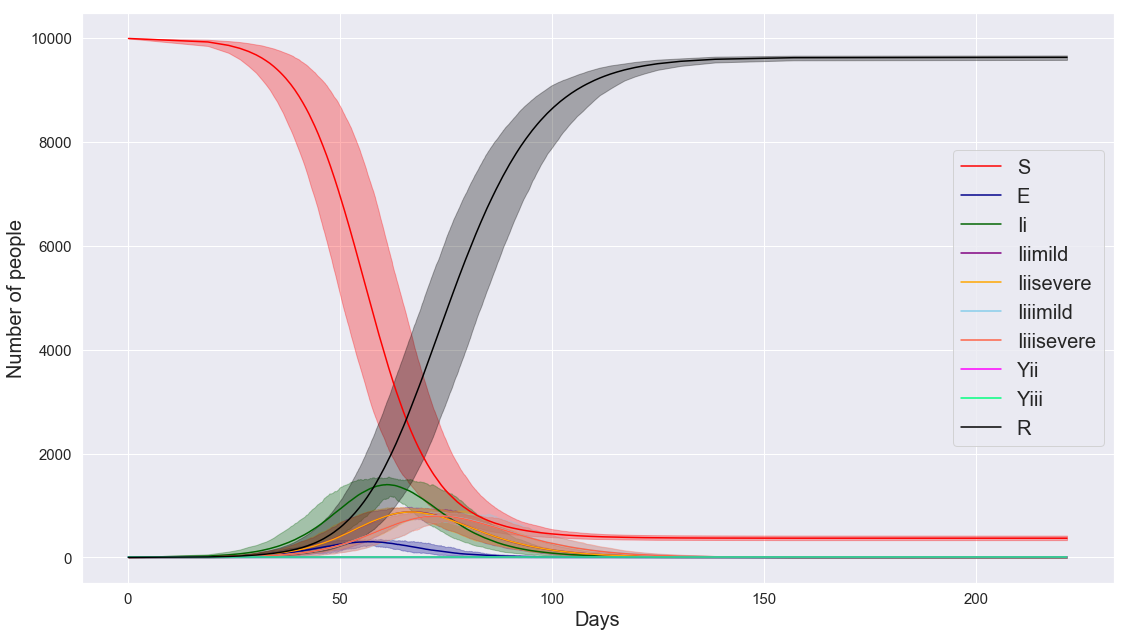

In [18]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()